<a href="https://colab.research.google.com/github/hunarpreet1/TradeAnomaly/blob/main/PriceVolumneAnomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date

folder_path = '/content/drive/My Drive/PriceData'

In [2]:
priceData = pd.read_csv(folder_path + '/' + 'pricedata.csv')
universe = pd.read_csv(folder_path + '/' + 'nse200universe.csv')

In [3]:
# around 3% data has volume missing
# around 0.1% data has price missing
priceData.set_index('date', inplace=True)
priceData.index = pd.to_datetime(priceData.index)
priceData.dropna(inplace=True) # Think about Nans later.....

In [4]:
priceData["totalVolume"] = priceData.groupby(level=0)["PX_VOLUME"].transform("sum")
priceData["maxStockVolume"] = priceData.groupby(level=0)["PX_VOLUME"].transform("max")
priceData["volume_ratio"] = priceData["PX_VOLUME"] / priceData["totalVolume"]
priceData["volume_max_ratio"] = priceData["PX_VOLUME"] / priceData["maxStockVolume"]

priceData['returnsOpen'] = priceData.groupby('security')['PX_OPEN'].pct_change()
priceData['returnsClose'] = priceData.groupby('security')['PX_LAST'].pct_change()
priceData['returnsHigh'] = priceData.groupby('security')['PX_HIGH'].pct_change()
priceData['returnsLow'] = priceData.groupby('security')['PX_LOW'].pct_change()
priceData.dropna(inplace=True) # Think about Nans later.....

In [5]:
priceData.columns

Index(['security', 'PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST',
       'EQY_WEIGHTED_AVG_PX', 'PX_VOLUME', 'totalVolume', 'maxStockVolume',
       'volume_ratio', 'volume_max_ratio', 'returnsOpen', 'returnsClose',
       'returnsHigh', 'returnsLow'],
      dtype='object')

In [6]:
IN_EQUITY_PREFIX = ' IN Equity'
CURR_UNIVERSE = [ ticker.split(' ')[0] for ticker in universe['2022-12-30'] if pd.notna(ticker) ]

In [7]:
CURR_UNIVERSE

['ABB',
 'ABCAP',
 'ABFRL',
 'ACC',
 'ACEM',
 'ADANIENS',
 'ADANIGR',
 'ADE',
 'ADSEZ',
 'AL',
 'ALKEM',
 'APHS',
 'APNT',
 'ARBP',
 'ASTRA',
 'ATGL',
 'AUBANK',
 'AWLTD',
 'AXSB',
 'BAF',
 'BANDHAN',
 'BATA',
 'BHARTI',
 'BHE',
 'BHEL',
 'BHFC',
 'BIL',
 'BIOS',
 'BJAUT',
 'BJFIN',
 'BJHI',
 'BOB',
 'BOI',
 'BOOT',
 'BOS',
 'BPCL',
 'BRGR',
 'BRIT',
 'CBK',
 'CCRI',
 'CIFC',
 'CIPLA',
 'CLEAN',
 'CLGT',
 'COAL',
 'COFORGE',
 'CRIN',
 'CROMPTON',
 'DABUR',
 'DALBHARA',
 'DELHIVER',
 'DIVI',
 'DIXON',
 'DLFU',
 'DLPL',
 'DMART',
 'DN',
 'DRRD',
 'EIM',
 'ESCORTS',
 'FB',
 'FORH',
 'GAIL',
 'GCPL',
 'GLAND',
 'GPL',
 'GRASIM',
 'GUJGA',
 'GUJS',
 'HAVL',
 'HCLT',
 'HDFC',
 'HDFCAMC',
 'HDFCB',
 'HDFCLIFE',
 'HMCL',
 'HMN',
 'HNAL',
 'HNDL',
 'HPCL',
 'HUVR',
 'HWA',
 'HZ',
 'ICICIBC',
 'ICICIGI',
 'IDEA',
 'IDFCFB',
 'IEX',
 'IGL',
 'IH',
 'IIB',
 'INBK',
 'INDIGO',
 'INDUSTOW',
 'INFO',
 'INFOE',
 'INMART',
 'IOCL',
 'IPCA',
 'IPRU',
 'IRCTC',
 'ISEC',
 'ITC',
 'JSP',
 'JSTL',
 'JSW',
 

In [8]:
def getStockPriceVolumeData(ticker, start=None, end=None):
  stock_data = priceData[priceData['security'] == ticker + IN_EQUITY_PREFIX]
  if start is not None:
    stock_data = stock_data.loc[start:]
  if end is not None:
    stock_data = stock_data.loc[:end]
  return stock_data

def plotPrice(ticker, priceType='PX_OPEN', start=None, end=None, dotDates=None, lineDates=None, saveFig=True, saveSuffix=''):
  df = getStockPriceVolumeData(ticker, start=start, end=end)
  plt.close("all")  # Close any previous plots
  fig, ax = plt.subplots(figsize=(10, 5))  # Create a new figure explicitly

  ax.plot(df.index, df[priceType], label=priceType, color='black')

  # Formatting
  ax.set_xlabel("Date")
  ax.set_ylabel(priceType)
  ax.set_title(ticker)
  ax.legend()
  plt.xticks(rotation=45)
  plt.grid()
  ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically adjusts date labels
  fig.autofmt_xdate()  # Rotates dates for better readability
  start = pd.Timestamp(start) if start is not None else df.index[0]
  end = pd.Timestamp(end) if end is not None else df.index[-1]

  if dotDates is not None:
    dotDates = [date for date in dotDates if date >= start and date <= end]
    plt.scatter(dotDates, df.loc[dotDates, priceType], color='red', zorder=3, label="Dots")

  if lineDates is not None:
    lineDates = [pd.Timestamp(date) for date in lineDates if start <= pd.Timestamp(date) <= end]
    print(lineDates)
    for date in lineDates:
        plt.axvline(x=date, color='blue', linestyle='--', linewidth=1, alpha=0.7, label="Event" if date == lineDates[0] else "")

  if saveFig:
    plt.savefig(ticker + '_' + saveSuffix + '.png', bbox_inches="tight")
    #print(f"Plot saved to {save_path}")

  plt.show()

#Model 1

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,4.5) # Make the default figures a bit bigger
import numpy as np
import random
import pandas as pd
from datetime import datetime
from datetime import date
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [10]:
'''
utoencoder Model: An autoencoder is implemented as a class AnomalyDetector that extends the tf.keras.models.Model class.
The autoencoder is composed of two parts: an encoder and a decoder.
The encoder reduces the dimensionality of the input data, and the decoder restores it to its original shape.
'''

# class AnomalyDetectorNN(Model):
#     def __init__(self, input_dim=30):
#         super(AnomalyDetectorNN, self).__init__()

#         # Encoder: Compress input into a smaller representation
#         self.encoder = tf.keras.Sequential([
#             layers.Dense(128, activation="relu", input_shape=(input_dim,)),  # Input shape added
#             layers.Dense(16, activation="relu")
#         ])

#         # Decoder: Reconstruct input from encoded representation
#         self.decoder = tf.keras.Sequential([
#             layers.Dense(128, activation="relu"),
#             layers.Dense(input_dim, activation="sigmoid")  # Ensures output matches input dimension
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)   # Encode input
#         decoded = self.decoder(encoded)  # Decode back to original shape
#         return decoded

# autoencoder = AnomalyDetectorNN(30)

class AnomalyDetectorNN(Model):
    def __init__(self, window_size=30, num_features=5):
        super(AnomalyDetectorNN, self).__init__()

        input_dim = window_size * num_features  # Flattened input size

        self.encoder = tf.keras.Sequential([
            layers.Flatten(),  # Convert (batch, 30, features) → (batch, 30*num_features)
            layers.Dense(128, activation="relu"),
            layers.Dense(16, activation="relu")
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation="relu"),
            layers.Dense(input_dim, activation="sigmoid"),  # Linear activation
            layers.Reshape((window_size, num_features))  # Reshape back to original
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# class LSTMAutoencoder(Model):
#     def __init__(self, input_dim=30, latent_dim=16):
#         super(LSTMAutoencoder, self).__init__()

#         # Encoder: Compress input into a smaller representation
#         self.encoder = tf.keras.Sequential([
#             layers.LSTM(128, activation="relu", return_sequences=True, input_shape=(input_dim, 1)),
#             layers.LSTM(latent_dim, activation="relu", return_sequences=False)  # Bottleneck
#         ])

#         # Decoder: LSTM reconstructing original input
#         self.decoder = tf.keras.Sequential([
#             layers.RepeatVector(input_dim),  # Expands bottleneck vector across time steps
#             layers.LSTM(128, activation="relu", return_sequences=True),
#             layers.TimeDistributed(layers.Dense(1))  # Output shape matches input (30,1)
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)  # Compress input into bottleneck representation
#         decoded = self.decoder(encoded)  # Reconstruct sequence from bottleneck
#         return decoded

# # Example usage
# input_dim = 30  # Sequence length (time steps)
# latent_dim = 8  # Compressed representation

# autoencoder = LSTMAutoencoder(input_dim=input_dim, latent_dim=latent_dim)
# #autoencoder.compile(optimizer='adam', loss='mae')

import tensorflow as tf
from tensorflow.keras import Model, layers

# class LSTMAutoencoder(Model):
#     def __init__(self, timeSteps=30, numFeatures=5, latent_dim=8):
#         super(LSTMAutoencoder, self).__init__()

#         # Encoder: Compress input into a latent representation
#         self.encoder = tf.keras.Sequential([
#             layers.LSTM(128, activation="relu", return_sequences=True, input_shape=(timeSteps, numFeatures)),
#             layers.LSTM(latent_dim, activation="relu", return_sequences=False)  # Bottleneck
#         ])

#         # Decoder: Reconstruct original input shape (timeSteps, numFeatures)
#         self.decoder = tf.keras.Sequential([
#             layers.RepeatVector(timeSteps),  # Expand bottleneck across time steps
#             layers.LSTM(128, activation="relu", return_sequences=True),
#             layers.TimeDistributed(layers.Dense(numFeatures))  # Ensure output matches input shape
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)  # Compress input into latent space
#         decoded = self.decoder(encoded)  # Reconstruct input from latent space
#         return decoded

class LSTMAutoencoder(Model):
    def __init__(self, timeSteps=30, numFeatures=5, latent_dim=16):
        super(LSTMAutoencoder, self).__init__()

        # Encoder: Compress input into a latent representation
        self.encoder = tf.keras.Sequential([
            layers.LSTM(128, activation="relu", return_sequences=True, input_shape=(timeSteps, numFeatures)),
            layers.LSTM(latent_dim, activation="relu", return_sequences=False)  # Keep sequences
        ])

        # Decoder: Reconstruct the original input shape (timeSteps, numFeatures)
        self.decoder = tf.keras.Sequential([
            layers.RepeatVector(timeSteps),  # Expand latent representation
            layers.LSTM(128, activation="relu", return_sequences=True),
            #layers.LSTM(64, activation="relu", return_sequences=True),  # Extra LSTM layer
            layers.TimeDistributed(layers.Dense(numFeatures))  # Ensure output matches input
        ])

    def call(self, x):
        encoded = self.encoder(x)  # Compress input
        decoded = self.decoder(encoded)  # Reconstruct input
        return decoded



In [12]:
'''
The autoencoder model is compiled with the adam optimizer and the mean absolute error (mae) as the loss function.
'''
autoencoder.compile(optimizer='adam', loss='mae')

NameError: name 'autoencoder' is not defined

In [15]:
def normalize_window_roll(data, window_size, step=1, cols_to_keep=None):
    """
    Normalizes a rolling window of data using MinMaxScaler.

    Parameters:
    - data: pd.DataFrame, with datetime index and multiple columns.
    - window_size: int, size of rolling window.
    - step: int, step size for moving window.
    - cols_to_keep: list, column names to keep for normalization.

    Returns:
    - X: np.array of shape (num_samples, window_size, num_features).
    - index_map: list of lists, mapping each index to dates.
    """

    X = []
    index_map = []

    # If cols_to_keep is provided, filter only those columns
    if cols_to_keep:
        data = data[cols_to_keep]

    for i in range(0, len(data) - window_size, step):
        x_window = data.iloc[i : i + window_size]  # Extract rolling window
        index_map.append(x_window.index.to_list())  # Store index list

        # Normalize across all selected columns
        scaler = MinMaxScaler(feature_range=(0, 1))
        x_window_scaled = scaler.fit_transform(x_window)  # Shape: (window_size, num_features)

        X.append(x_window_scaled)

    X = np.array(X)  # Shape: (num_samples, window_size, num_features)

    return X, index_map



In [23]:
import numpy as np
import pandas as pd

def split_data(X, index_map, test_start, test_end, val_start, val_end):
    """
    Splits data into train, validation, and test sets based on given date ranges.

    Parameters:
    - X: np.array (N_data x seq_length x num_features), the normalized rolling window data.
    - index_map: list of lists containing pd.Timestamp (N_data x seq_length), mapping each index in X to a sequence of dates.
    - test_start: datetime.date or pd.Timestamp, start date for test set.
    - test_end: datetime.date or pd.Timestamp, end date for test set.
    - val_start: datetime.date or pd.Timestamp, start date for validation set.
    - val_end: datetime.date or pd.Timestamp, end date for validation set.

    Returns:
    - X_train, X_val, X_test: np.array, split data (same 3D shape structure).
    - index_train, index_val, index_test: list of lists of pd.Timestamp.
    """

    # Convert all date inputs to pd.Timestamp for consistency
    test_start, test_end = pd.Timestamp(test_start), pd.Timestamp(test_end)
    val_start, val_end = pd.Timestamp(val_start), pd.Timestamp(val_end)

    # Ensure index_map is not empty
    if not index_map:
        seq_length = X.shape[1] if X.ndim == 3 else 0
        num_features = X.shape[2] if X.ndim == 3 else 0
        return (np.empty((0, seq_length, num_features)),  # X_train
                np.empty((0, seq_length, num_features)),  # X_val
                np.empty((0, seq_length, num_features)),  # X_test
                [], [], [])  # Empty index lists

    # Extract representative date (first date of each sequence in index_map)
    index_representative = np.array([dates[0] for dates in index_map])

    # Identify test indices
    test_mask = (index_representative >= test_start) & (index_representative <= test_end)
    test_indices = np.where(test_mask)[0]
    X_test = X[test_indices] if len(test_indices) > 0 else np.empty((0, X.shape[1], X.shape[2]))
    index_test = [index_map[i] for i in test_indices] if len(test_indices) > 0 else []

    # Identify validation indices
    val_mask = (index_representative >= val_start) & (index_representative <= val_end)
    val_indices = np.where(val_mask)[0]
    X_val = X[val_indices] if len(val_indices) > 0 else np.empty((0, X.shape[1], X.shape[2]))
    index_val = [index_map[i] for i in val_indices] if len(val_indices) > 0 else []

    # Remaining data for training
    train_mask = ~(test_mask | val_mask)
    train_indices = np.where(train_mask)[0]
    X_train = X[train_indices] if len(train_indices) > 0 else np.empty((0, X.shape[1], X.shape[2]))
    index_train = [index_map[i] for i in train_indices] if len(train_indices) > 0 else []

    return X_train, X_val, X_test, index_train, index_val, index_test


In [17]:
#Source: https://www.tensorflow.org/tutorials/generative/autoencoder
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions, data), axis=1)
  return tf.math.less(loss, threshold)

In [ ]:
#reconstructions.shape
#X_train.shape
train_loss.shape

Epoch 1/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.2234 - val_loss: 0.1612
Epoch 2/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1531 - val_loss: 0.1416
Epoch 3/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1425 - val_loss: 0.1268
Epoch 4/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1253 - val_loss: 0.1170
Epoch 5/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1150 - val_loss: 0.1104
Epoch 6/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1098 - val_loss: 0.1025
Epoch 7/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1020 - val_loss: 0.0970
Epoch 8/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0978 - val_loss: 0.0943
Epoch 9/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0975 - val_loss: 0.0918
Epoch 10/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0888 - val_loss: 0.0885
Epoch 11/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0893 - val_loss: 0.0859
Epoch 12/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0849 - val_l

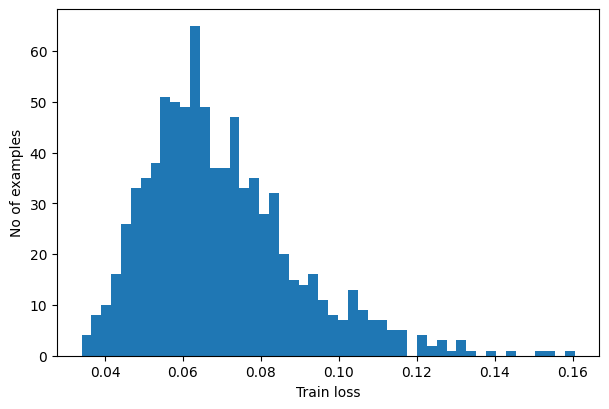

Threshold:  0.08951782113105033
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


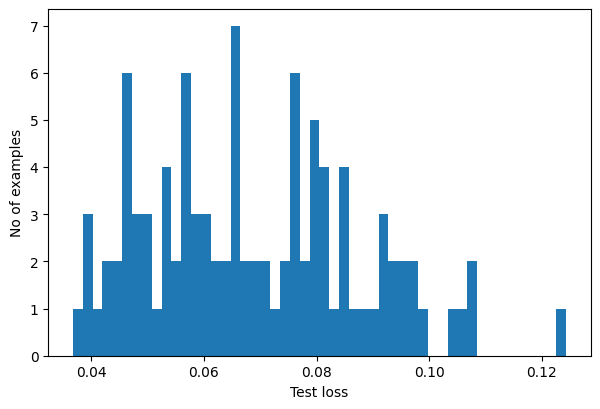

[Timestamp('2019-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00')]


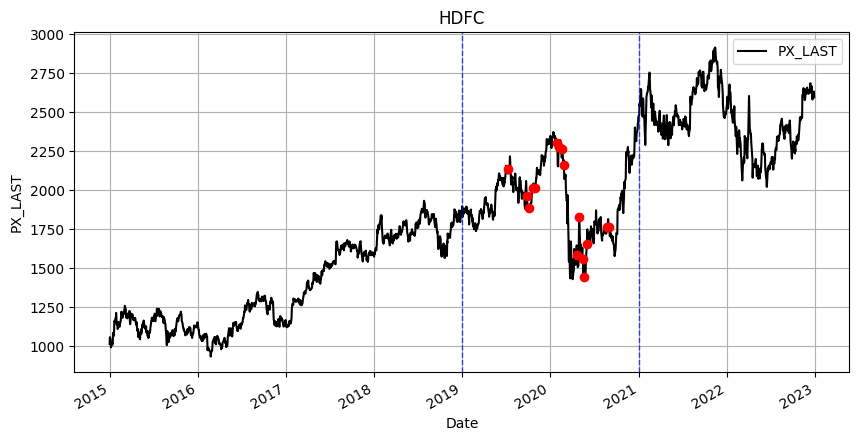

Epoch 1/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2354 - val_loss: 0.1615
Epoch 2/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1487 - val_loss: 0.1310
Epoch 3/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1266 - val_loss: 0.1221
Epoch 4/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1188 - val_loss: 0.1131
Epoch 5/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1092 - val_loss: 0.1049
Epoch 6/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1042 - val_loss: 0.0975
Epoch 7/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0943 - val_loss: 0.0943
Epoch 8/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0925 - val_loss: 0.0898
Epoch 9/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0882 - val_loss: 0.0868
Epoch 10/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0849 - val_loss: 0.0840
Epoch 11/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0821 - val_loss: 0.0816
Epoch 12/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0805 - v

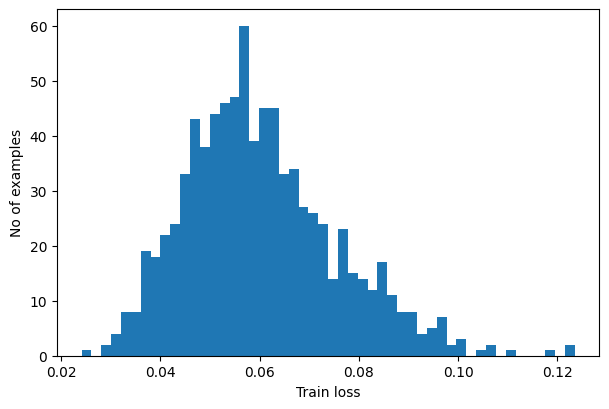

Threshold:  0.07552712683477843
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


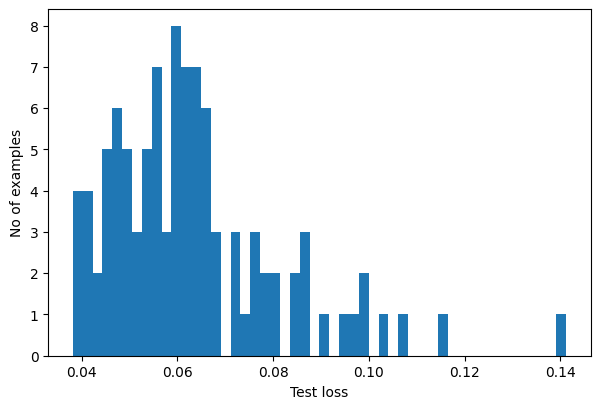

[Timestamp('2019-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00')]


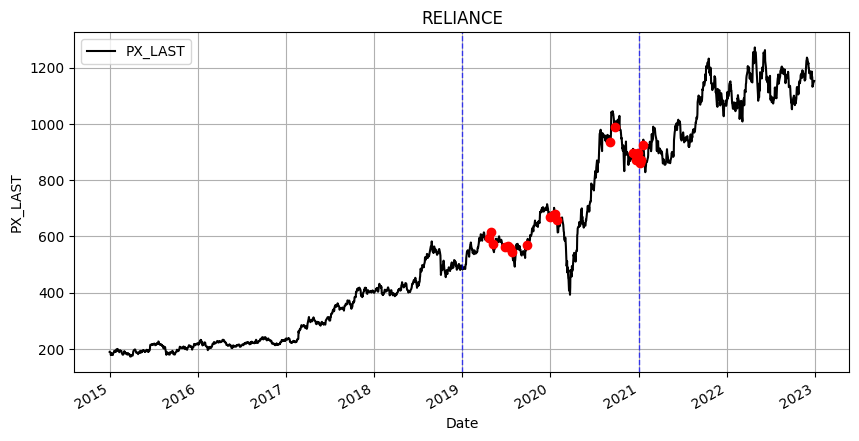

Epoch 1/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2389 - val_loss: 0.1668
Epoch 2/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1463 - val_loss: 0.1383
Epoch 3/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1260 - val_loss: 0.1216
Epoch 4/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1119 - val_loss: 0.1126
Epoch 5/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1054 - val_loss: 0.1064
Epoch 6/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1008 - val_loss: 0.1023
Epoch 7/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0972 - val_loss: 0.0972
Epoch 8/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0905 - val_loss: 0.0929
Epoch 9/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0887 - val_loss: 0.0901
Epoch 10/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0855 - val_loss: 0.0844
Epoch 11/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0800 - val_loss: 0.0809
Epoch 12/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0770 - val

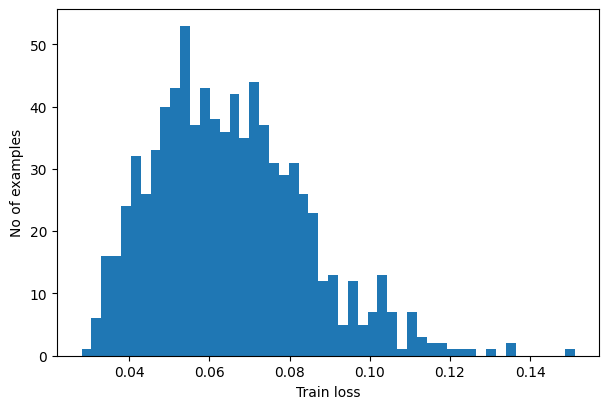

Threshold:  0.08430722464415782
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


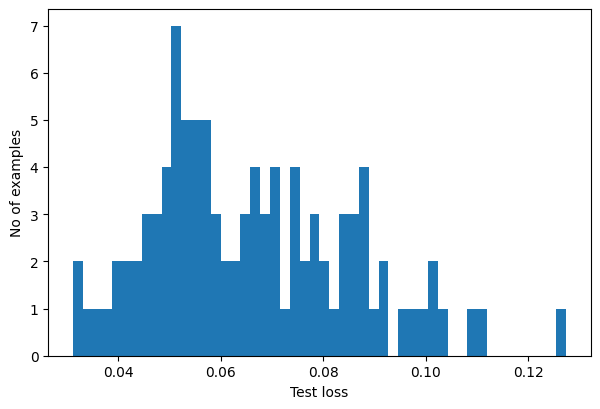

[Timestamp('2019-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00')]


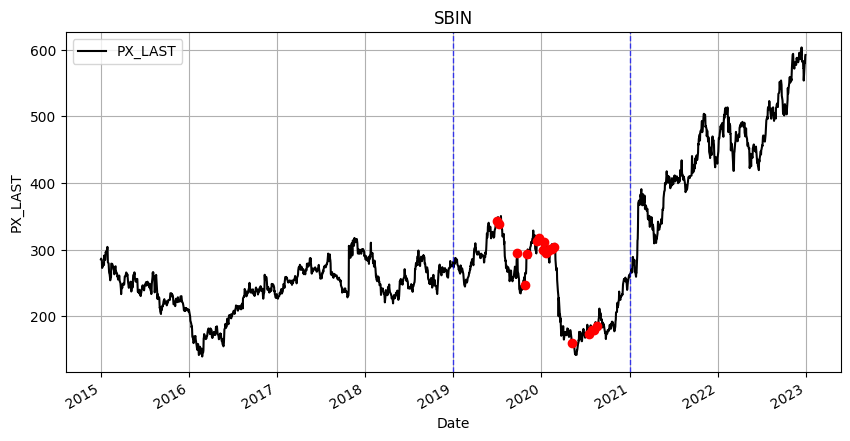

In [38]:
#TICKERS = CURR_UNIVERSE
TICKERS = ['HDFC', 'RELIANCE', 'SBIN']
PRICE_TYPE = 'PX_LAST'
#COLS_TO_KEEP = ['PX_LAST','PX_OPEN', 'PX_HIGH', 'PX_LOW', 'volume_max_ratio' ]
#COLS_TO_KEEP = ['PX_LAST','PX_OPEN', 'PX_HIGH', 'PX_LOW', 'volume_ratio' ]
#COLS_TO_KEEP = ['returnsClose','returnsOpen', 'returnsHigh', 'returnsLow', 'volume_max_ratio' ]
COLS_TO_KEEP = [ 'PX_LAST' ]
# input_dim = 30
# latent_dim = 8
MODEL_INFO = ""
returnsAtAnomalies = {}

for ticker in TICKERS:
  try:
    prices = getStockPriceVolumeData(ticker)

    X, index_map = normalize_window_roll(prices,30,5,COLS_TO_KEEP)
    startTest = date(2019, 1, 1)
    endTest = date(2021, 1, 1)

    startVal = date(2014, 1, 1)
    endVal = date(2018, 1, 1)

    X_train, X_val, X_test, index_train, index_val, index_test = split_data(X, index_map, startTest, endTest, startVal, endVal)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

    ########################### CHANGE MDOEL HERE ###########################

    autoencoder = AnomalyDetectorNN(30, 1)
    #autoencoder = LSTMAutoencoder(30, 1, 16)
    autoencoder.compile(optimizer='adam', loss='mae')

    history = autoencoder.fit(X_train,X_train, epochs=80,
                        validation_data=(X_val, X_val),
                        batch_size=16,
                        callbacks=[early_stopping])

    reconstructions = autoencoder.predict(X_train)
    train_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions, X_train), axis=1)

    plt.hist(train_loss[None,:], bins=50)
    plt.xlabel("Train loss")
    plt.ylabel("No of examples")
    plt.show()

    threshold = np.mean(train_loss) + np.std(train_loss)
    #threshold = np.max(train_loss)
    print("Threshold: ", threshold)

    reconstructions = autoencoder.predict(X_test)
    test_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions, X_test), axis=1)

    plt.hist(test_loss[None, :], bins=50)
    plt.xlabel("Test loss")
    plt.ylabel("No of examples")
    plt.show()

    preds = predict(autoencoder, X_test, threshold)

    anomalousIndexIds  = np.where(preds == False)[0]

    dotDates = [index_test[i][-1] for i in anomalousIndexIds]
    plotPrice(ticker, PRICE_TYPE, date(2015, 1, 1), None, dotDates, lineDates=[startTest, endTest], saveSuffix=autoencoder.__class__.__name__ + MODEL_INFO)

    returns = calculate_returns(prices, dotDates)
    returnsAtAnomalies[ticker] = returns

  except Exception as e:
    print(f"Error processing {ticker}: {e}")

returnsAtAnomaliesDf = pd.concat(
    [df.assign(Ticker=ticker) for ticker, df in returnsAtAnomalies.items()],
    ignore_index=True
)
results = evaluate_predictions(returnsAtAnomaliesDf)
results.to_csv('results' + autoencoder.__class__.__name__ + MODEL_INFO + '.csv')


In [39]:
evaluate_predictions(returnsAtAnomaliesDf)

,Ticker,Total Anomalies,|3M Return| > 10%,|6M Return| > 10%,|3M Return| > 20%,|6M Return| > 20%
0,HDFC,16,14,14,8,11
1,RELIANCE,21,9,14,3,8
2,SBIN,19,15,17,13,17


In [33]:
returnsAtAnomaliesDf

,Anomaly Date,Price at Anomaly,3M Return,6M Return,Ticker
0,2019-02-13,1821.26,1.341379,9.799260,HDFC
1,2019-09-04,1999.73,10.585429,5.045181,HDFC
2,2019-09-12,1983.21,11.317006,-9.940954,HDFC
3,2019-09-26,1964.60,17.007533,-15.992059,HDFC
4,2019-10-04,1883.75,20.512807,-21.389250,HDFC
5,2019-10-22,2013.83,14.265355,-21.313120,HDFC
6,2019-10-29,2012.07,13.780833,-13.076086,HDFC
7,2020-01-30,2299.58,-20.662469,-24.180503,HDFC
8,2020-04-30,1824.43,-4.434262,1.524312,HDFC
9,2020-07-27,1782.14,10.298854,33.297608,HDFC


#Direction of trade

In [12]:
import pandas as pd
import numpy as np

def signalFromAnomaly(data, anomalyDates):
    """
    Generate trading signals based on anomalies using trend & mean reversion filters.

    Parameters:
    data (pd.DataFrame): DataFrame with 'Close' prices and date index.
    anomalyDates (list): List of dates (as strings) where anomalies were detected.

    Returns:
    pd.DataFrame: Original DataFrame with a new 'Signal' column.
    """
    df = data.copy()

    # Ensure the index is a datetime index
    df.index = pd.to_datetime(df.index)

    # Compute Moving Averages
    df['SMA_5'] = df['PX_LAST'].rolling(window=5).mean()
    df['SMA_20'] = df['PX_LAST'].rolling(window=20).mean()

    # Compute Bollinger Bands
    rolling_mean = df['PX_LAST'].rolling(window=20).mean()
    rolling_std = df['PX_LAST'].rolling(window=20).std()
    df['BB_Upper'] = rolling_mean + (2 * rolling_std)
    df['BB_Lower'] = rolling_mean - (2 * rolling_std)

    # Compute RSI manually
    delta = df['PX_LAST'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain).rolling(window=14, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=14, min_periods=1).mean()

    rs = avg_gain / (avg_loss + 1e-10)  # Avoid division by zero
    df['RSI'] = 100 - (100 / (1 + rs))

    # Compute Momentum (5-day return)
    df['Momentum'] = df['PX_LAST'].pct_change(periods=5)

    # Initialize Signal Column
    df['Signal'] = 0

    # Generate Signals
    for date in anomalyDates:
        date = pd.to_datetime(date)
        if date in df.index:
            sma5 = df.loc[date, 'SMA_5']
            sma20 = df.loc[date, 'SMA_20']
            rsi = df.loc[date, 'RSI']
            close = df.loc[date, 'PX_LAST']
            upper_bb = df.loc[date, 'BB_Upper']
            lower_bb = df.loc[date, 'BB_Lower']
            momentum = df.loc[date, 'Momentum']

            # Trend-Following: Buy if SMA5 > SMA20 (Uptrend), Sell if SMA5 < SMA20 (Downtrend)
            if sma5 > sma20:
                signal = 1  # Buy
            elif sma5 < sma20:
                signal = -1  # Sell
            else:
                signal = 0  # No clear trend

            # Mean Reversion Filters
            if close >= upper_bb or rsi > 70:
                signal = -1  # Overbought, Sell
            elif close <= lower_bb or rsi < 30:
                signal = 1  # Oversold, Buy

            # Momentum Confirmation (Only take trade if past returns support it)
            if momentum > 0 and signal == 1:
                signal = 0  # Avoid buying into strong price rise
            elif momentum < 0 and signal == -1:
                signal = 0  # Avoid selling into strong decline

            df.loc[date, 'Signal'] = signal

    return df

#Quality of Trade

In [37]:
import pandas as pd

def calculate_returns(df, anomaly_dates, months=[3, 6]):
    """
    Compute 3-month and 6-month returns from anomaly dates, selecting the next available date if missing.

    Parameters:
    df (pd.DataFrame): DataFrame with 'PX_LAST' prices and datetime index.
    anomaly_dates (list): List of anomaly dates (as strings or datetime).
    months (list): List of months for return calculation (default: [3, 6]).

    Returns:
    pd.DataFrame: Table with anomaly dates, 3M & 6M returns.
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)  # Ensure index is datetime
    sorted_dates = df.index.sort_values()  # Ensure index is sorted
    results = []

    for date in anomaly_dates:
        anomaly_date = pd.to_datetime(date)
        if anomaly_date not in df.index:
            continue  # Skip if anomaly date is missing

        price_at_anomaly = df.loc[anomaly_date, "PX_LAST"]
        row = {"Anomaly Date": anomaly_date, "Price at Anomaly": price_at_anomaly}

        for m in months:
            future_date = anomaly_date + pd.DateOffset(months=m)

            # Find the next available date if the exact future date is missing
            future_idx = sorted_dates.searchsorted(future_date)
            if future_idx < len(sorted_dates):  # Ensure index is within bounds
                adjusted_future_date = sorted_dates[future_idx]
                future_price = df.loc[adjusted_future_date, "PX_LAST"]
                return_m = (future_price - price_at_anomaly) * 100 / price_at_anomaly
                row[f"{m}M Return"] = return_m
            else:
                row[f"{m}M Return"] = None  # No future data available

        results.append(row)

    return pd.DataFrame(results)


import pandas as pd
import numpy as np

def evaluate_predictions(returns_df):
    """
    Compute statistics to evaluate anomaly-based predictions.

    Parameters:
    returns_df (pd.DataFrame): DataFrame containing 'Ticker', 'Anomaly Date', '3M Return', '6M Return'.

    Returns:
    pd.DataFrame: Summary table with counts of strong movements.
    """
    stats = []

    for ticker, group in returns_df.groupby("Ticker"):
        total_anomalies = len(group)

        # Count occurrences where absolute return exceeds threshold
        count_abs_3m_10 = (group["3M Return"].abs() > 10).sum()
        count_abs_6m_10 = (group["6M Return"].abs() > 10).sum()
        count_abs_3m_20 = (group["3M Return"].abs() > 20).sum()
        count_abs_6m_20 = (group["6M Return"].abs() > 20).sum()

        stats.append({
            "Ticker": ticker,
            "Total Anomalies": total_anomalies,
            "|3M Return| > 10%": count_abs_3m_10,
            "|6M Return| > 10%": count_abs_6m_10,
            "|3M Return| > 20%": count_abs_3m_20,
            "|6M Return| > 20%": count_abs_6m_20
        })

    return pd.DataFrame(stats)


#Volume normalization (DON)

#Remove index component (NEED INDEX TIME SERIES)

#Use all features (DONE)

# Rough

In [ ]:
TICKER = 'SBIN'
PRICE_TYPE = 'PX_LAST'
prices = getStockPriceVolumeData(TICKER, start=date(2010, 1, 1))[PRICE_TYPE]
prices.rename('price', inplace=True)
prices.dropna(inplace=True) # only 2 nan dates for reliance for eg.

In [ ]:
# should we smoothen the data ?
X, index_map = normalize_window_roll(prices,30)

In [ ]:
print(X.shape)
print(prices.shape)
print(len(index_map))

In [ ]:
train_size = int(0.7*X.shape[0])
test_size = int(0.1*X.shape[0])
val_size = int(0.2*X.shape[0])

X_train = X[:train_size]
X_val = X[train_size+test_size:train_size+val_size+test_size]
X_test = X[train_size:train_size+test_size]

val_index_offset = train_size + test_size
test_index_offset = train_size
#X_val = X[train_size+test_size:train_size+test_size+val_size]

In [ ]:
'''
Training the model: The autoencoder is trained using the stock market data using the fit function.
An EarlyStopping callback is added to stop the training if the validation loss does not improve for 2 consecutive epochs.
'''
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(X_train,X_train, epochs=80,
                    validation_data=(X_val, X_val),
                    batch_size=16,
                    callbacks=[early_stopping])

In [ ]:
#Source: https://www.tensorflow.org/tutorials/generative/autoencoder
reconstructions = autoencoder.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions, X_train)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

In [ ]:
np.mean(train_loss)

In [ ]:
reconstructions = autoencoder.predict(X_test)
test_loss = tf.keras.losses.mae(reconstructions, X_test)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
preds = predict(autoencoder, X_test, threshold)

In [ ]:
preds

In [ ]:
anomalous_test_data = X_test[np.where(preds==False)]

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

for p in [1,10,20]:
  plt.plot(anomalous_test_data[p], 'b')
  plt.plot(np.arange(0,X.shape[1]),decoded_data[p], 'r')
  plt.fill_between(np.arange(X.shape[1]), decoded_data[p], anomalous_test_data[p], color='lightcoral')
  plt.legend(labels=["Input", "Reconstruction", "Error"])
  plt.show()

#Visualize on original price plot

In [ ]:
anomalousIndexIds  = np.where(preds == False)[0]
anomalousIndexIds = [ int(test_index_offset + id) for id in anomalousIndexIds ]

In [ ]:
#dotDates = [date for i in anomalousIndexIds for date in index_map[i]]
dotDates = [index_map[i][0] for i in anomalousIndexIds]

In [ ]:
dotDates

In [ ]:
plotPrice(TICKER, 'PX_LAST', date(2013, 1, 1), None, dotDates, lineDates=[index_map[val_index_offset][0], index_map[test_index_offset][0]])

In [ ]:
ticker

In [ ]:
prices.index[test_index_offset]

In [ ]:
val_index_offset

In [ ]:
test_index_offset